In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dm2022-isa5810-lab2-homework/tweets_DM.json
/kaggle/input/dm2022-isa5810-lab2-homework/sampleSubmission.csv
/kaggle/input/dm2022-isa5810-lab2-homework/data_identification.csv
/kaggle/input/dm2022-isa5810-lab2-homework/emotion.csv


# 1. Data Preprocessing
[illustration](img/pic1.png)
![Data preprocessing](./img/pic1.png)

#### Data source:
- /kaggle/input/dm2022-isa5810-lab2-homework/tweets_DM.json
- /kaggle/input/dm2022-isa5810-lab2-homework/data_identification.csv
- /kaggle/input/dm2022-isa5810-lab2-homework/emotion.csv

#### Steps:
1. Read tweets_DM.json and use json_normalize to transform content in '_source' into dataframe. Constains 'tweet_id'.
2. Read emotion.csv to get corresponding label(emotion). Join text by 'tweet_id'.
3. Read data_identification.csv to get train/test label. Join text by 'tweet_id'.
4. Apply data preprocessing function(code by myself) to clean up raw tweets.
5. Split into training and validation dataset.

#### Preprocess Func:
1. demojize emoji into text
2. Remove user (start from @)
3. Replace website as 'https'
4. Remove symbol
5. Lower case


In [3]:
#import Package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from datasets import load_dataset
from datasets import Dataset

#Read Json File
tweet_raw = load_dataset("json", data_files="/kaggle/input/dm2022-isa5810-lab2-homework/tweets_DM.json")
tweet_raw = tweet_raw['train']['_source']

"""
Other data route
/kaggle/input/dm2022-isa5810-lab2-homework/sampleSubmission.csv
/kaggle/input/dm2022-isa5810-lab2-homework/data_identification.csv
/kaggle/input/dm2022-isa5810-lab2-homework/emotion.csv
"""
#Read CSV data
data_iden = pd.read_csv('/kaggle/input/dm2022-isa5810-lab2-homework/data_identification.csv')
data_label = pd.read_csv('/kaggle/input/dm2022-isa5810-lab2-homework/emotion.csv')

#Transform to pandas dataframe for later preprocessing
tweet_df = pd.json_normalize(tweet_raw)
tweet_df.columns= ['hashtags','tweet_id','text_raw']
tweet_df = tweet_df.join(data_iden.set_index('tweet_id'), on='tweet_id')
tweet_df = tweet_df.join(data_label.set_index('tweet_id'), on='tweet_id')
tweet_df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,hashtags,tweet_id,text_raw,identification,emotion
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN


### Let's see the preprocess func and an example

In [4]:
import re
import emoji

def preprocess(text):
    new_text = []
    text = emoji.demojize(text).replace('face_with_',' ').replace('_',' ').replace(':',' ')
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = 'website' if t.startswith('http') else t
        t = t.replace('#','').replace('<LH>','')
        t = re.sub(r'\W+', ' ', t)
        new_text.append(t.lower())
    return " ".join([i for i in new_text if i !=''])

a = 'Now @ISSA is stalking Tasha 😂😂😂 <LH>'
preprocess(a)

'now is stalking tasha tears of joy tears of joy tears of joy'

In [12]:
##Apply to all the dataset, it may take some time
tweet_df["text"]= tweet_df.text_raw.apply(lambda x: preprocess(x))

train_df = tweet_df[tweet_df.identification=='train']
test_df = tweet_df[tweet_df.identification=='test']
train_df = train_df.dropna(axis=1)

In [7]:
##The result after pre-processing
test_df.head(5)

,hashtags,tweet_id,text_raw,identification,emotion,text
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,NaN,confident of your obedience i write to you k...
4,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN,trust is not the same as faith a friend is s...
9,"[materialism, money, possessions]",0x218443,When do you have enough ? When are you satisfi...,test,NaN,when do you have enough when are you satisfi...
30,"[GodsPlan, GodsWork]",0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test,NaN,god woke you up now chase the day godsplan go...
33,[],0x26289a,"In these tough times, who do YOU turn to as yo...",test,NaN,in these tough times who do you turn to as yo...


In [ ]:
#Split train and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    train_df.text, train_df.emotion,
    test_size = 0.25,   
    shuffle = True,
    random_state=42)

tweets = X_train
labels = Y_train

#Set validation dataset
val_tweets = X_val
val_labels = Y_val

# 2. Feature engineering

1. Downlaod pre-trained W2V model "glove-twitter-25" (length:25)
2. Tokenize by apply tokenizer from tensorflow 
3. Withing W2V model and tokenizer can create embedding matrix
4. pad_sequences from tensorflow (truncating='post', maxlen=40, padding='post')

In [8]:
#import pre-trained word2vector model 
import gensim.downloader as api
w2v_model = api.load("glove-twitter-25")
w2v_model['sad']

[================================================--] 97.7% 102.4/104.8MB downloaded


array([ 0.044072, -0.19031 ,  0.44185 , -0.15418 , -0.6026  ,  0.04668 ,
        1.4741  ,  0.14376 , -0.72328 ,  0.43288 , -1.7557  ,  0.41221 ,
       -4.0419  ,  0.40469 , -0.17825 ,  0.83272 ,  0.64866 ,  0.12397 ,
       -0.17873 , -0.59851 ,  0.67779 ,  1.0177  , -0.31664 ,  0.18662 ,
       -0.17645 ], dtype=float32)

In [88]:
#Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='')
tokenizer.fit_on_texts(train_df.text)

In [89]:
#Create embedding_matrix
import numpy as np

vocab_size = len(tokenizer.word_index) + 1 
word_index = tokenizer.word_index
embedding_dim = 25
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for w in word_index:
    idx = word_index[w] 
    try:
        embedding_matrix[idx] = np.array(w2v_model[w], dtype=np.float32)[:embedding_dim]
    except:
        pass

In [92]:
#Padding Sequence, max_length=40
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

padded_train_sequences = get_sequences(tokenizer, tweets)
val_sequences = get_sequences(tokenizer, val_tweets)

In [93]:
#Encode classes
classes = set(labels)
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
val_labels = names_to_ids(Y_val)

print(classes_to_index)

{'fear': 0, 'surprise': 1, 'sadness': 2, 'disgust': 3, 'joy': 4, 'anger': 5, 'anticipation': 6, 'trust': 7}


# 3. Model summary

- Construct a model with LSTM.
- Loss: 'sparse_categorical_crossentropy'
- Apply early stop(Criteria: val_accuracy patience=2)

In [118]:
#Compile Model
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
import tensorflow as tf

embedding_dim = 25
maxlen = 40
model = Sequential()
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='softmax'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 25)            12258675  
_________________________________________________________________
lstm_13 (LSTM)               (None, 40, 128)           78848     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 264       
Total params: 12,473,499
Trainable params: 214,824
Non-trainable params: 12,258,675
____________________________________

In [ ]:
"""
#Model without w2v
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense#, and all the other layers you may use
from tensorflow.keras.regularizers import l2
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 32, input_length=40),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy', #'sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()
"""

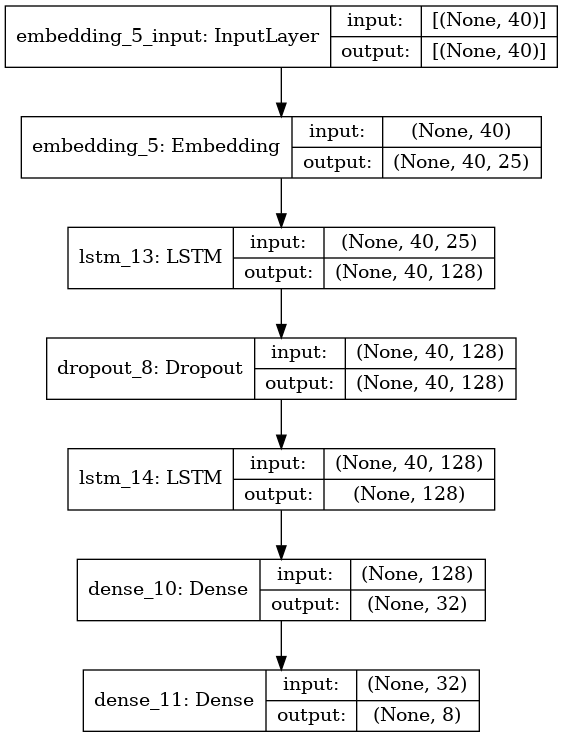

In [119]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [120]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=100,batch_size=1000,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/100
1092/1092 [==============================] - 38s 32ms/step - loss: 1.5315 - acc: 0.4324 - val_loss: 1.4572 - val_acc: 0.4597
Epoch 2/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.4203 - acc: 0.4751 - val_loss: 1.3996 - val_acc: 0.4852
Epoch 3/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.3789 - acc: 0.4925 - val_loss: 1.3669 - val_acc: 0.4971
Epoch 4/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.3511 - acc: 0.5042 - val_loss: 1.3460 - val_acc: 0.5066
Epoch 5/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.3284 - acc: 0.5134 - val_loss: 1.3266 - val_acc: 0.5139
Epoch 6/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.3094 - acc: 0.5216 - val_loss: 1.3125 - val_acc: 0.5204
Epoch 7/100
1092/1092 [==============================] - 34s 31ms/step - loss: 1.2942 - acc: 0.5276 - val_loss: 1.2982 - val_acc: 0.5257
Epoch 8/100
1092/1092 [==================

# 4. Training Result

In [122]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

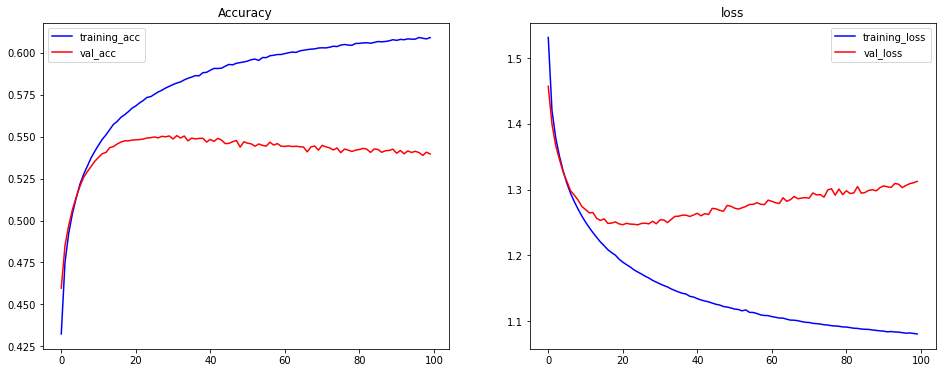

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(acc, color='blue',label = 'training_acc')
plt.plot(val_acc, color='red',label = 'val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, color='blue',label = 'training_loss')
plt.plot(val_loss, color='red',label = 'val_loss')
plt.legend()
plt.title('loss')

plt.show()

### Interpret
The model converged at the early stage. While the training accuracy keep raising, the enhancement of validation accuracy was slowing down even decreasing. The final training accuracy is higher than validation accuracy, which means the model is a little bit overfitting. As for the final prediction, the model didn't fit as well as training and validation dataset.

# 5. Make prediction

In [127]:
##prdeiction 
predict_dict = {}
classes = list(classes)

#the first 10 ows
test_tweets = test_df.iloc[:10]
test_sequences = get_sequences(tokenizer, test_tweets.text)
test_logits = model.predict(test_sequences)

for i,pred in zip(test_tweets.tweet_id, test_logits):
    predict_dict.update({i:classes[pred.argmax()]})

predict_dict

{'0x28b412': 'anticipation',
 '0x2de201': 'trust',
 '0x218443': 'joy',
 '0x2939d5': 'joy',
 '0x26289a': 'trust',
 '0x31c6e0': 'anticipation',
 '0x32edee': 'sadness',
 '0x3714ee': 'anger',
 '0x235628': 'joy',
 '0x283024': 'sadness'}

In [ ]:
##Saving all predict result
#Using for loop  to prevent OOM
"""
predict_dict = {}
classes = list(classes)

for i in range(1,int(test_df.shape[0]/10000)+1): #round(test_df.shape[0]/100)
    print((i-1)*10000,i*10000)
    test_tweets = test_df.iloc[(i-1)*10000:i*10000]
    test_sequences = get_sequences(tokenizer, test_tweets.text)
    test_logits = model.predict(test_sequences)
    
    for i,pred in zip(test_tweets.tweet_id, test_logits):
        predict_dict.update({i:classes[pred.argmax()]})
        
test_tweets = test_df.iloc[410000:]
test_sequences = get_sequences(tokenizer, test_tweets.text)
test_logits = model.predict(test_sequences)

for i,pred in zip(test_tweets.tweet_id, test_logits):
    predict_dict.update({i:classes[pred.argmax()]})
    
### save result
output = pd.DataFrame([predict_dict]).T
output.columns=['emotion']
output.index.name = 'id'
output.to_csv('./pred.csv')
"""

## 3-4 Some Finding

#### Data imbalance issue
The dataset is highly imbalance. Therefore, the model tend to guess the majority class, such as 'joy', 'anticipation' and 'trust'. 

In [144]:
emotion_count = train_df.value_counts('emotion')
emotion_count/sum(emotion_count)

emotion
joy             0.354514
anticipation    0.171023
trust           0.141167
sadness         0.132895
disgust         0.095565
fear            0.043969
surprise        0.033478
anger           0.027389
dtype: float64

#### Ambiguous sentiment
There are 8 type of emotions, which are: 'fear', 'surprise', 'sadness', 'disgust', 'joy', 'anger', 'anticipation', 'trust'. However, words in positive classes are easily mess up with each other. On the other hand, words in negative classes are easily mess up with each other.

#### Irony expression
People sometimes use irony expression or emoji which may interfere the model.

#### w2v model
The performance of using w2v model is better than not using. But the improvement is not that much. Maybe the fundamental is to leverage on more powerful model like BERT, extract the latent feature than train a model. Actually, I have tried to use pretrained BERT model on huggingface, but the result is bad. The loss nearly no change during training process.  The model only predict the majority class. Therefore, I chose LSTM to do the final implement. 